In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from data_analysis import run_tsne, plot_tsne

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import shap

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, LeaveOneOut, RepeatedStratifiedKFold

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
data_source = 'C:/Users/BiSBII/Documents/MM_ML/data/'

In [5]:
metabolomics_file = 'metabolomics.xlsx'
metadata_file = 'metabolomics_metadata.csv'

### 1) data with replicates

In [12]:
data_reps = pd.read_excel(os.path.join(data_source, metabolomics_file), index_col=0)
metadata_reps = pd.read_csv(os.path.join(data_source, metadata_file), index_col=0)
data_reps = data_reps.loc[:, data_reps.columns != 'Method']
data_reps = data_reps.transpose()
data_reps.shape

(219, 212)

### 2) data without replicates

In [13]:
metadata_noreps_groups = pd.read_excel(os.path.join(data_source, 'metabolomics_metadata.xlsx'), sheet_name='CONVERSION', index_col=0)

In [14]:
data_noreps = data_reps.groupby(metadata_noreps_groups['groups']).mean()

In [15]:
metadata_noreps = pd.read_excel(os.path.join(data_source, 'metabolomics_metadata.xlsx'), sheet_name='NO_REPLICATES', index_col=0)

In [16]:
y_state_reps = metadata_reps['factor']
y_state_noreps = metadata_noreps['factor']

In [17]:
y_state_noreps.sort_index(key=lambda column: column.map(lambda e: list(data_noreps.index).index(e)), inplace=True)

# UNSUPERVISED ANALYSIS

In [35]:
vt = VarianceThreshold(0)
data_filtered = vt.fit_transform(data_noreps)
cols_inds = vt.get_support(indices=True)
df_data_filtered = pd.DataFrame(data_filtered, index=data_noreps.index, columns=data_noreps.columns[cols_inds])
df_data_filtered.shape

(73, 208)

In [36]:
df_tsne = run_tsne(n_components=2, data=df_data_filtered)

In [37]:
df_tsne['factor'] = y_state_noreps

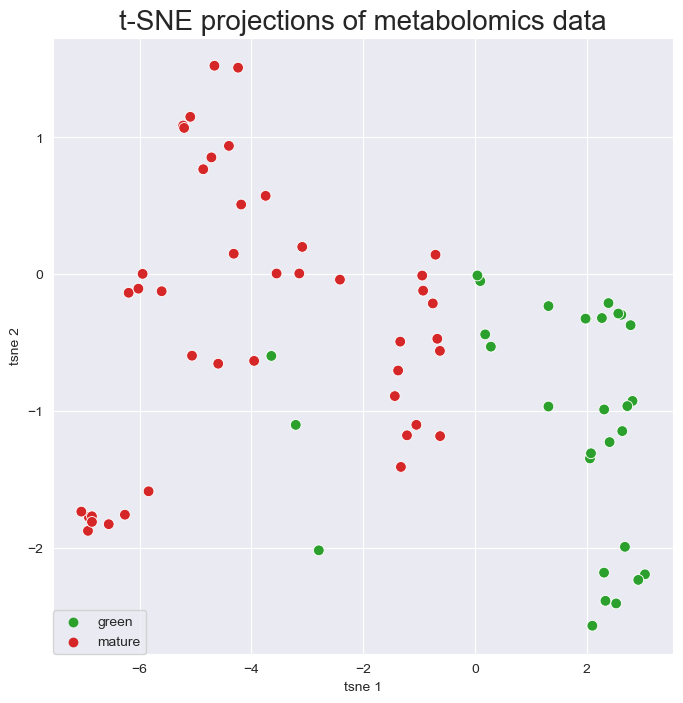

In [38]:
plot_tsne(data=df_tsne, name_fig='tsne_mets_noreps', title='t-SNE projections of metabolomics data')

# SUPERVISED ANALYSIS

In [15]:
binary = {'green': 0, 'mature': 1}
binary_output = y_state_noreps.map(binary)

In [16]:
scaler = StandardScaler()
vt = VarianceThreshold(0.001)
scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1, n_repeats=10)

In [18]:
data = data_noreps

### LR

In [42]:
lr_cv = LogisticRegression()

pipe_lr = Pipeline([('transformer1', vt), ('transformer3', scaler), ('estimator', lr_cv)])

scores_lr = cross_validate(pipe_lr, data, binary_output, cv=cv, scoring=scoring)

print('test_accuracy', round(scores_lr['test_accuracy'].mean(), 2))
print('test_balanced_accuracy', round(scores_lr['test_balanced_accuracy'].mean(), 2))
print('test_precision', round(scores_lr['test_precision'].mean(), 2))
print('test_recall', round(scores_lr['test_recall'].mean(), 2))
print('test_f1', round(scores_lr['test_f1'].mean(), 2))

test_accuracy 0.95
test_balanced_accuracy 0.94
test_precision 0.95
test_recall 0.97
test_f1 0.96


### RF

In [43]:
rf_cv = RandomForestClassifier(random_state=1)

pipe_rf = Pipeline([('transformer1', vt), ('transformer3', scaler), ('estimator', rf_cv)])

scores_rf = cross_validate(pipe_rf, data, binary_output, cv=cv, scoring=scoring, return_estimator=True)

print('test_accuracy', round(scores_rf['test_accuracy'].mean(), 2))
print('test_balanced_accuracy', round(scores_rf['test_balanced_accuracy'].mean(), 2))
print('test_precision', round(scores_rf['test_precision'].mean(), 2))
print('test_recall', round(scores_rf['test_recall'].mean(), 2))
print('test_f1', round(scores_rf['test_f1'].mean(), 2))

test_accuracy 0.97
test_balanced_accuracy 0.96
test_precision 0.96
test_recall 1.0
test_f1 0.98


### KNN

In [45]:
knn_cv = KNeighborsClassifier()

pipe_knn = Pipeline([('transformer1', vt), ('transformer3', scaler), ('estimator', knn_cv)])

scores_knn = cross_validate(pipe_knn, data, binary_output, cv=cv, scoring=scoring)
for key in scores_knn:
    print(key, round(scores_knn[key].mean(), 2))

fit_time 0.02
score_time 0.03
test_accuracy 0.92
test_balanced_accuracy 0.92
test_precision 0.95
test_recall 0.92
test_f1 0.93


### DT

In [46]:
tree_cv = tree.DecisionTreeClassifier(random_state=1)

pipe_tree = Pipeline([('transformer1', vt), ('transformer3', scaler), ('estimator', tree_cv)])

scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

scores_tree = cross_validate(pipe_tree, data, binary_output, cv=cv, scoring=scoring)
for key in scores_tree:
    print(key, round(scores_tree[key].mean(), 2))

fit_time 0.02
score_time 0.01
test_accuracy 0.91
test_balanced_accuracy 0.91
test_precision 0.93
test_recall 0.93
test_f1 0.92


### svm

In [47]:
svm_cv = svm.SVC()

pipe_svm = Pipeline([('transformer1', vt), ('transformer3', scaler), ('estimator', svm_cv)])

scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

scores_svm = cross_validate(pipe_svm, data, binary_output, cv=cv, scoring=scoring)
for key in scores_svm:
    print(key, round(scores_svm[key].mean(), 2))

fit_time 0.02
score_time 0.01
test_accuracy 0.93
test_balanced_accuracy 0.93
test_precision 0.94
test_recall 0.97
test_f1 0.95


### svm linear

In [48]:
svm_l_cv = svm.SVC(kernel='linear')

pipe_svm_l = Pipeline([('transformer1', vt), ('transformer3', scaler), ('estimator', svm_l_cv)])

scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

scores_svm_l = cross_validate(pipe_svm_l, data, binary_output, cv=cv, scoring=scoring, return_estimator=True)

print('test_accuracy', round(scores_svm_l['test_accuracy'].mean(), 2))
print('test_balanced_accuracy', round(scores_svm_l['test_balanced_accuracy'].mean(), 2))
print('test_precision', round(scores_svm_l['test_precision'].mean(), 2))
print('test_recall', round(scores_svm_l['test_recall'].mean(), 2))
print('test_f1', round(scores_svm_l['test_f1'].mean(), 2))

test_accuracy 0.93
test_balanced_accuracy 0.92
test_precision 0.94
test_recall 0.95
test_f1 0.94


# SHAP VALUES

In [18]:
CV_repeats = 10
cv_repeated = RepeatedStratifiedKFold(n_splits=10, random_state=1, n_repeats=10)
scores_knn = {'accuracy': [], 'balanced_accuracy': [], 'precision': [], 'recall': [], 'f1': []}

scaler = StandardScaler()
vt = VarianceThreshold(0.001)

In [19]:
scores_rf = {'accuracy': [], 'balanced_accuracy': [], 'precision': [], 'recall': [], 'f1': []}

In [20]:
shap_values_per_cv = dict()
for sample in data.index:
    shap_values_per_cv[sample] = {} 
    for CV_repeat in range(CV_repeats):
        shap_values_per_cv[sample][CV_repeat] = {}

In [21]:
rep = 0    
for i, (train_index, test_index) in enumerate(cv_repeated.split(data, binary_output)):
    
    train = data.iloc[train_index, :]
    test = data.iloc[test_index, :]

    y_train = binary_output.iloc[train_index]
    y_test = binary_output.iloc[test_index]

    filter_train = vt.fit(train)

    train_filtered = filter_train.transform(train)
    test_filtered = filter_train.transform(test)

    cols_inds = vt.get_support(indices=True)

    X_train_filtered = pd.DataFrame(train_filtered, index=train.index, columns=train.columns[cols_inds])

    X_test_filtered = pd.DataFrame(test_filtered, index=test.index, columns=test.columns[cols_inds])

    features_selected = train.columns[cols_inds]

    scaler_model = StandardScaler().fit(X_train_filtered)
    X_train_scaled = scaler_model.transform(X_train_filtered)
    X_test_scaled = scaler_model.transform(X_test_filtered)
    X_train_final = pd.DataFrame(X_train_scaled, columns=X_train_filtered.columns, index=X_train_filtered.index)
    X_test_final = pd.DataFrame(X_test_scaled, columns=X_test_filtered.columns, index=X_test_filtered.index)

    rf = RandomForestClassifier(random_state=1)

    rf.fit(X_train_final, y_train)

    rf_y_pred = rf.predict(X_test_final)

    scores_rf['accuracy'].append(accuracy_score(y_test, rf_y_pred))
    scores_rf['balanced_accuracy'].append(balanced_accuracy_score(y_test, rf_y_pred))
    scores_rf['precision'].append(precision_score(y_test, rf_y_pred))
    scores_rf['recall'].append(recall_score(y_test, rf_y_pred))
    scores_rf['f1'].append(f1_score(y_test, rf_y_pred))

    explainer = shap.Explainer(rf.predict, X_test_final, max_evals=1100, seed=42)
    shap_values = explainer(X_test_final)
    
    df = pd.DataFrame(shap_values.values, columns=features_selected, index=[data.index[i] for i in test_index])
    for ind in df.index:
        shap_values_per_cv[ind][rep] = df.loc[[ind]]
    
    splits = [9, 19, 29, 39, 49, 59, 69, 79, 89]
    if i in splits:
        rep += 1
    
print('accuracy', round(np.array(scores_rf['accuracy']).mean(), 2))
print('balanced_accuracy', round(np.array(scores_rf['balanced_accuracy']).mean(), 2))
print('precision', round(np.array(scores_rf['precision']).mean(), 2))
print('recall', round(np.array(scores_rf['recall']).mean(), 2))
print('f1', round(np.array(scores_rf['f1']).mean(), 2))

accuracy 0.97
balanced_accuracy 0.96
precision 0.96
recall 1.0
f1 0.98


In [22]:
average_shap_values = []

for sample in shap_values_per_cv:
    sample_dfs = [shap_values_per_cv[sample][rep] for rep in shap_values_per_cv[sample]] 
    concat_df = pd.concat(sample_dfs, axis=0)
    concat_df = concat_df.fillna(0)
    mean_df = concat_df.mean(axis=0)
    mean_df.name = sample
    average_shap_values.append(mean_df)

In [23]:
concat_mean = pd.concat(average_shap_values, axis=1).transpose()
concat_mean = concat_mean.fillna(0)
concat_mean.shape

(73, 208)

In [24]:
final_shap_array = np.array(concat_mean)

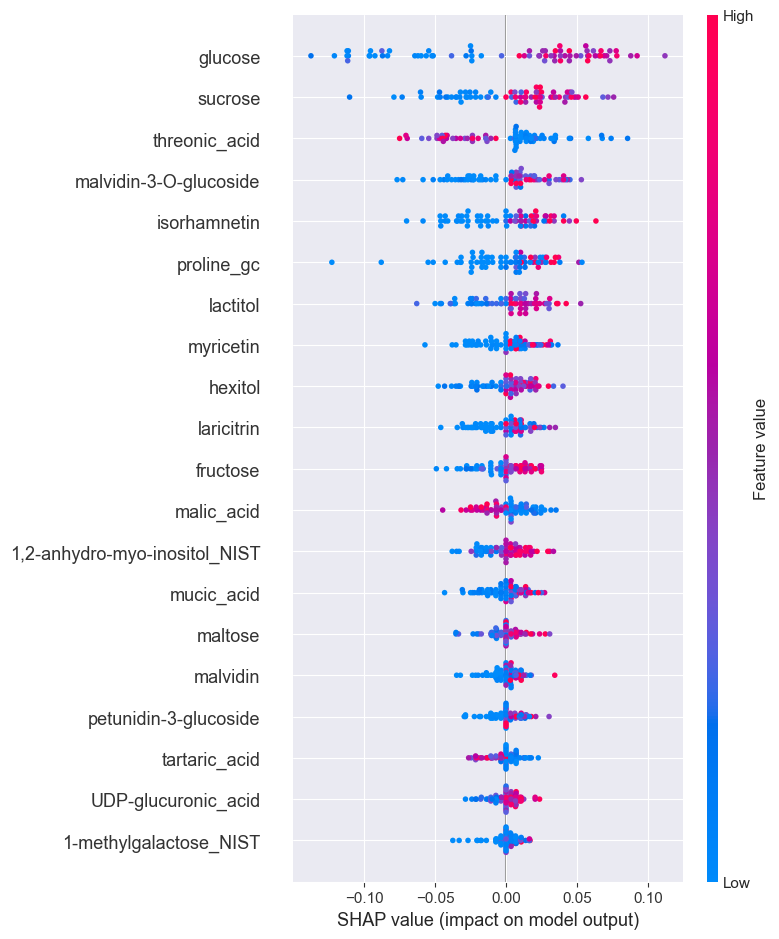

In [25]:
shap.summary_plot(final_shap_array, data[concat_mean.columns])